In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot

from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        data = np.genfromtxt(file_path, delimiter=',')
       
        # Obtenga el numero de peatones en el conjunto de datos actual
        #uni = np.unique(data[:,1])    
        numPeds = np.size(np.unique(data[:,1]))
     
        print("peatones.............")
        print(numPeds)
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:
#data_dirs = ['../data1/ucy/zara/zara01']
#data_dirs = ['../data1/ucy/univ']
data_dirs = ['../data1/pets']
datasets = [0]
used_data_dirs = [data_dirs[x] for x in datasets]
      
# Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_.cpkl")

name='pixel_pos_2.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,12,1)#los ultimos dos valores noimportan

peatones.............
19


In [5]:
def secuencia(seq_length_obs,data):
    tamano = int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-1
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i+seq_length_obs, :]  
            Y.append(b-a[len(a)-1,:])
    return np.array(X), np.array(Y)

In [7]:
import random
random.seed(0)
datos = np.array(datos)


array_new = arange(len(datos))
random.shuffle(array_new)
longitud = len(array_new)
train_size = int(longitud * 0.80)
test_size = longitud-train_size

train = datos[array_new[0:train_size]]
test = datos[array_new[train_size:]]

print("Cantidad total peatones", len(datos))
print("Peatones para entrenamiento es " ,len(train))
print("Peatones para test es " ,len(test))


('Cantidad total peatones', 19)
('Peatones para entrenamiento es ', 15)
('Peatones para test es ', 4)


In [8]:
trainX,trainY = secuencia(8,train)

In [9]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))

In [10]:
data_shape = trainX.shape[1:]
print(data_shape)

import numpy as np
np.shape(trainX)

(8, 2)


(1888, 8, 2)

In [11]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime

if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

W1120 17:17:55.734373 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1120 17:17:55.768697 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 17:17:55.772187 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [12]:
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile( optimizer = opt,loss='logcosh',metrics=['mse'])
history1 = model.fit(trainX, trainY, epochs=80, batch_size=15, verbose=2 )


W1120 17:17:57.970031 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1120 17:17:57.976077 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W1120 17:17:58.194794 139991211140864 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1120 17:17:59.417587 139991211140864 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_a

Epoch 1/80
 - 2s - loss: 1.2913e-04 - mean_squared_error: 2.5847e-04
Epoch 2/80
 - 1s - loss: 3.9868e-05 - mean_squared_error: 7.9743e-05
Epoch 3/80
 - 1s - loss: 2.8965e-05 - mean_squared_error: 5.7937e-05
Epoch 4/80
 - 1s - loss: 2.0011e-05 - mean_squared_error: 4.0025e-05
Epoch 5/80
 - 1s - loss: 1.4145e-05 - mean_squared_error: 2.8294e-05
Epoch 6/80
 - 1s - loss: 1.1575e-05 - mean_squared_error: 2.3156e-05
Epoch 7/80
 - 1s - loss: 1.0531e-05 - mean_squared_error: 2.1067e-05
Epoch 8/80
 - 1s - loss: 9.8107e-06 - mean_squared_error: 1.9626e-05
Epoch 9/80
 - 1s - loss: 9.5604e-06 - mean_squared_error: 1.9124e-05
Epoch 10/80
 - 1s - loss: 9.1792e-06 - mean_squared_error: 1.8363e-05
Epoch 11/80
 - 1s - loss: 8.7298e-06 - mean_squared_error: 1.7461e-05
Epoch 12/80
 - 1s - loss: 8.5091e-06 - mean_squared_error: 1.7019e-05
Epoch 13/80
 - 1s - loss: 8.4146e-06 - mean_squared_error: 1.6833e-05
Epoch 14/80
 - 1s - loss: 8.2188e-06 - mean_squared_error: 1.6443e-05
Epoch 15/80
 - 1s - loss: 8.0

In [13]:
history_dict1 = history1.history
history_dict1.keys()

['mean_squared_error', 'loss']

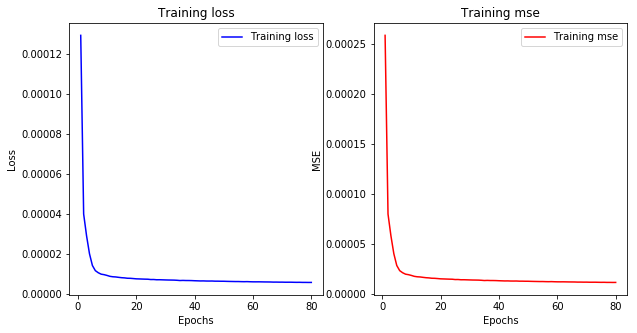

In [14]:
acc = history1.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history1.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#model.save('lstm-ucy-zara-zara01_solo.h5')

In [ ]:
#model.save('lstm-ucy-univ_solo.h5')

In [ ]:
#model.save('lstm-pets_solo.h5')

In [ ]:
#model.save('lstm-pets1_solo.h5')

In [15]:
#model.save('lstm-pets_simplificado_solo.h5')

In [16]:
modeldxdy = load_model('lstm-pets_simplificado_solo.h5')# la de 8 pasos observados

In [17]:
def error_promedio(predicted_traj, true_traj, seq_length_obs):
    
    error = np.zeros(len(true_traj) - seq_length_obs)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(seq_length_obs, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-seq_length_obs] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [18]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [19]:
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [20]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan normalizados
"""


def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i]) 
        
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade=[t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
        
    

In [21]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en marco pixeles
"""
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    
    trayectoria=[]
    verdadero=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([640* traj_pred[k,0],480*traj_pred[k,1]])
        #    traj_tr.append([640* Y_true[i][k,0],480*Y_true[i][k,1]])
        
        #traj_pre = np.array(traj_pre)
        #traj_tr = np.array(traj_tr)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        # calcular ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre ,traj_tr,seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    #return trayectoria, verdadero

In [ ]:
sample(test,8,2)

In [23]:
sample_en_pixeles(test,8,4)

ADE
5.584197255449434
5.584197255449432
FDE
9.27128732767099
